In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import json
import pandas as pd

In [2]:
# Plotting Helpers

from __future__ import division, print_function, absolute_import

import numpy as np
from matplotlib.colors import ColorConverter
from matplotlib import rcParams


__author__ = 'Felix Berkenkamp / Johannes Kirschner'
__all__ = ['set_figure_params', 'emulate_color', 'linewidth_in_data_units',
           'adapt_figure_size_from_axes', 'cm2inches', 'hide_all_ticks',
           'hide_spines', 'set_frame_properties']


def emulate_color(color, alpha=1, background_color=(1, 1, 1)):
    """Take an RGBA color and an RGB background, return the emulated RGB color.
    The RGBA color with transparency alpha is converted to an RGB color via
    emulation in front of the background_color.
    """
    to_rgb = ColorConverter().to_rgb
    color = to_rgb(color)
    background_color = to_rgb(background_color)
    return [(1 - alpha) * bg_col + alpha * col
            for col, bg_col in zip(color, background_color)]


def cm2inches(centimeters):
    """Convert cm to inches"""
    return centimeters / 2.54


def set_figure_params(serif=True):
    """Define default values for font, fontsize and use latex
    Parameters
    ----------
    serif: bool, optional
        Whether to use a serif or sans-serif font
    """

    params = {
              'font.family': 'serif',
              'font.serif': ['Times',
                             'Palatino',
                             'New Century Schoolbook',
                             'Bookman',
                             'Computer Modern Roman'],
              'font.sans-serif': ['Times',
                                  'Helvetica',
                                  'Avant Garde',
                                  'Computer Modern Sans serif'],
              'text.usetex': True,
              # Make sure mathcal doesn't use the Times style
              'text.latex.preamble':
              r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}',

              'axes.labelsize': 9,
              'axes.linewidth': .75,

              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,

              # 'figure.dpi': 150,
              # 'savefig.dpi': 600,
              # 'legend.numpoints': 1,
              }

    if not serif:
        params['font.family'] = 'sans-serif'

    rcParams.update(params)


def hide_all_ticks(axis):
    """Hide all ticks on the axis.
    Parameters
    ----------
    axis: matplotlib axis
    """
    axis.tick_params(axis='both',        # changes apply to the x-axis
                     which='both',       # affect both major and minor ticks
                     bottom='off',       # ticks along the bottom edge are off
                     top='off',          # ticks along the top edge are off
                     left='off',         # No ticks left
                     right='off',        # No ticks right
                     labelbottom='off',  # No tick-label at bottom
                     labelleft='off')    # No tick-label at bottom


def hide_spines(*axes, top=True, right=True):
    
    for axis in axes:
        """Hide the top and right spine of the axis."""
        if top:
            axis.spines['top'].set_visible(False)
            axis.xaxis.set_ticks_position('bottom')
        if right:
            axis.spines['right'].set_visible(False)
            axis.yaxis.set_ticks_position('left')


def set_frame_properties(axis, color, lw):
    """Set color and linewidth of frame."""
    for spine in axis.spines.values():
        spine.set_linewidth(lw)
        spine.set_color(color)


def linewidth_in_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.
    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.
    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()

    if reference == 'x':
        # width of the axis in inches
        axis_length = fig.get_figwidth() * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        axis_length = fig.get_figheight() * axis.get_position().height
        value_range = np.diff(axis.get_ylim())

    # Convert axis_length from inches to points
    axis_length *= 72

    return (linewidth / value_range) * axis_length


def adapt_figure_size_from_axes(axes):
    """
    Adapt the figure sizes so that all axes are equally wide/high.
    When putting multiple figures next to each other in Latex, some
    figures will have axis labels, while others do not. As a result,
    having the same figure width for all figures looks really strange.
    This script adapts the figure sizes post-plotting, so that all the axes
    have the same width and height.
    Be sure to call plt.tight_layout() again after this operation!
    This doesn't work if you have multiple axis on one figure and want them
    all to scale proportionally, but should be an easy extension.
    Parameters
    ----------
    axes: list
        List of axes that we want to have the same size (need to be
        on different figures)
    """
    # Get parent figures
    figures = [axis.get_figure() for axis in axes]

    # get axis sizes [0, 1] and figure sizes [inches]
    axis_sizes = np.array([axis.get_position().size for axis in axes])
    figure_sizes = np.array([figure.get_size_inches() for figure in figures])

    # Compute average axis size [inches]
    avg_axis_size = np.average(axis_sizes * figure_sizes, axis=0)

    # New figure size is the average axis size plus the white space that is
    # not begin used by the axis so far (e.g., the space used by labels)
    new_figure_sizes = (1 - axis_sizes) * figure_sizes + avg_axis_size

    # Set new figure sizes
    for figure, size in zip(figures, new_figure_sizes):
        figure.set_size_inches(size)
        
def plot_errorbars(axis, x, y, err, num=10, sigma=2, **kwargs):
    T = len(y)

    if axis.get_xscale() == 'log':
        l,h = x[0], x[-1]
        a = (h/l)**(1/num)
        b = np.log(l)/np.log(a)
        pos = np.power(a, np.linspace(b, b+num, num))
        pos = (pos - pos[0])/pos[-1]
        pos = np.floor(pos*np.linspace(1, len(x)-1, num=num)).astype(int)
        
        xpos = x[pos]
        ypos = y[pos]
        width = sigma*err[pos]
    else:
        pos = np.floor(np.linspace(0, len(x)-1, num=num)).astype(int)
        xpos = x[pos]
        ypos = y[pos]
        width = sigma*err[pos]
    
    axis.errorbar(xpos, ypos, width, 
                  ecolor=emulate_color('black', alpha=0.6),
                     capsize=2,
                     capthick=0.3,
                     elinewidth=0.3,
                     linewidth=0.6,
                     fmt="none",
                     errorevery=1,
                     **kwargs)

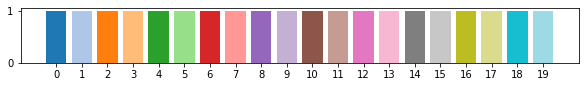

In [3]:
# define tableau colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
(188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.figure(figsize=(10,1))
for i,c in enumerate(tableau20):
    plt.bar(i,1, color=c)

    
plt.xticks([*range(20)])
plt.show()

In [4]:
TEXTWIDTH = 15.23782  # width from latex paper

In [5]:
def load_data(env_path, basedir):
    """ helper function to load aggregated data """
    data = dict()
    
    for path in glob.iglob(os.path.join(basedir, env_path, '*/'), recursive=False):
        strategy = path.rsplit(os.sep, maxsplit=3)[2]
        env = path.rsplit(os.sep, maxsplit=3)[1]
        env, horizon = env.split('-')
        horizon = int(horizon)
        
#         print(env, strategy)

        strategy_dict = dict()
        
        
        # get all files that where created for regret aggregation, there might be multiple
        aggr_files = [os.path.split(f)[1] for f in glob.iglob(path + 'aggr-*.csv')]
        print(aggr_files)
        
        if len(aggr_files) == 0:
            continue
            
        with open(os.path.join(path, 'params.json')) as json_file:
            args = json.load(json_file)
        
        name = strategy.split('-')[0]
        strategy_dict['args'] = args
        strategy_dict['algorithm'] = name
        strategy_dict['env'] = env
        strategy_dict['n'] = horizon
        args_str = ','.join(f"{k}={v}" for k,v in args.items())
        strategy_dict['algorithm_args'] = f"{name}-{args_str}"
                                                        
        # find different aggregators and use the largest one
        aggr_dict = {}
        count = 0
        for file in aggr_files:
            _, aggr, count = file.split('-')
            count = int(count[:-4])  # shave of '.csv' suffix
            if aggr_dict.get(aggr, (0, None))[0] < count:
                aggr_dict[aggr] = count, file
                        
        for aggr, (count, file) in aggr_dict.items():
            # store data
            print(f"{name}: reading {file} with {count} runs.")
            strategy_dict[aggr] = pd.read_csv(os.path.join(path, file), delimiter=" ", header=None).values

#             strategy_dict[aggr] = np.loadtxt(os.path.join(path, file))
        strategy_dict['repetitions'] = count
        
        data[strategy] = strategy_dict
        
    data = {k : v for k,v in sorted(data.items(), key=lambda i: i[1]['algorithm_args']) }
    return env, data

In [6]:
def plot_regret(data, axis, exclude=None, color_fct=None, label_fct=None, line_fct=None, n=None, n0=0):
    
    color_idx = 0
    lines = []
    for strategy, strategy_data in data.items():
        if exclude is not None and exclude(strategy_data):
            continue

        regret = strategy_data['regret']
        if n is None:
            n = strategy_data['n']
        x=np.arange(n0, n)
        rep = strategy_data['repetitions']
        
        # get label
        label = None
        if label_fct is not None:
            label = label_fct(strategy_data)
        if label is None:
            label = strategy
            
        # get color
        color = None
        if color_fct is not None:
            color = color_fct(strategy_data)
        if color is None:
            color = tableau20[color_idx]
            color_idx += 1
            
        line = None
        if line_fct is not None:
            line = line_fct(strategy_data)
        if line is None:
            line = '-'
        
        lines.append(axis.plot(x, regret[n0:n, 0], label=label, color=color, linewidth=1, linestyle=line))
        plot_errorbars(axis, x, regret[n0:n, 0], regret[n0:n, 1]/np.sqrt(rep), num=10, sigma=2)
    return lines

In [33]:
# only_logdet = True

def exclude_fct(strategy_data):
    """ exclude specific runs from plotting """
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if args.get('beta_logdet'):
        return False
    
    if algorithm == 'SolidOld':
        return True    
    
    if algorithm == 'TS':
        return True
    
    if algorithm == 'Solid' and args.get('solid_z0')==100:
        return True
    #     if args.get('solid_z0')== False:
#         return False
        
    if strategy_data['algorithm'] == 'AsymptoticIDS':
        if not args['ids_fast_info']:
            return True
    
    return False


def label_fct(strategy_data):
    """ read data for strategy and return a label. By default, returns the algorithm name. """
    label = strategy_data['algorithm']
    args = strategy_data['args']
    if args['beta_logdet']:
        return ''
    if label == 'AsymptoticIDS':
        if args.get('ids_fast_info'):
            label = 'IDS'#'Fast' + label
        else:
            label = 'IDS-Cell'
        if args.get('opt2'):
            label += r'-$I^{\textsc{ucb}}$'
    if label == 'Solid':
        if not args.get('solid_reset'):
            label += '++'
    if label == 'UCB':
        label = 'LinUCB'

    return label

def color_fct(strategy_data):
    label = strategy_data['algorithm']
    args = strategy_data['args']
    
    if label == 'AsymptoticIDS':
        if args['ids_fast_info']:
            if args['opt2']:
                return tableau20[0]
            return tableau20[1]
        else:
            if args['opt2']:
                return tableau20[8]
            return tableau20[9]
    
    if label == 'Solid':
        if args['solid_reset']:
            return tableau20[2]
        return tableau20[3]
    if label == 'UCB':
        return tableau20[4]
    
    raise RuntimeError(f"Unknown Algorithm: {label}")


def line_fct(strategy_data):
    args = strategy_data['args']
    # include only logdet results
    if args['beta_logdet']:
        return ':'
    if strategy_data['algorithm'] == 'AsymptoticIDS':
        if not args['ids_fast_info']:
            return '--'
    
    return '-'

In [11]:
basedir = '../runs-colt2021-final'
experiments = [
#     'large_gaps_v0.1-1000000', 
    'simple_bandit_v0.1-1000000',
    'counter_example_v0.1_e0.01_a0.5-1000000'
]

# read all experiments at once:
combined_data = []
for exp_name in experiments:
    combined_data.append(load_data(exp_name, basedir=basedir))

['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
UCB: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-67.csv']
Solid: reading aggr-regret-67.csv with 67 runs.
['aggr-regret-100.csv']
TS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
Solid: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-61.csv']
Solid: reading aggr-regret-61.csv with 61 runs.
['aggr-regret-100.csv']
Solid: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
TS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['aggr-regret-100.csv']
AsymptoticIDS: reading aggr-regret-100.csv with 100 runs.
['ag

<ipython-input-35-fcd2d4444c70>:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines,     # The line objects
<ipython-input-35-fcd2d4444c70>:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff670ed1f10> has a label of '_line6' which cannot be automatically added to the legend.
  fig.legend(lines,     # The line objects
<ipython-input-35-fcd2d4444c70>:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff6704bdac0> has a label of '_line9' which cannot be automatically added to the legend.
  fig.legend(lines,     # The line objects
<ipython-input-35-fcd2d4444c70>:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff6705f7160> has a label of '_line12' which cannot be automatically added to the legend.
  fig.legend(lines,     # The line objects
<ipython-input-35-fcd2d4444c70>:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff6705dca90> has a label of '_line15' which 

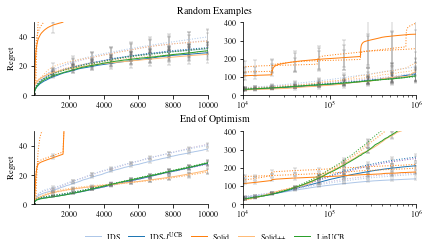

In [35]:
# 2 x 2 ploth

fig, axes = plt.subplots(ncols=2, nrows=2)
## uncomment this line to transpose the plot:
# axes = list(map(list, zip(*axes))) # transpose axes array

# some generic figure improvements
set_figure_params()
fig.set_size_inches(cm2inches(TEXTWIDTH),3.0)


# mapping environment names to plot properties:
props ={
#     'large_gaps_v0.1' : dict(
#         xlims=((1, 1e4), (1e4, 1e6)),
#         ylims=(None, None),
#         title='Large Gaps',
#     ),
    'simple_bandit_v0.1' : dict(
        xlims=((1, 1e4), (1e4, 1e6)),
        ylims=((0, 50), (0, 400)),
        title=('Random Bandit (finite time)','Random Bandit (large horizon)'),
        ylabel='Regret'
    ),
    'counter_example_v0.1_e0.01_a0.5' : dict(
        xlims=((1, 1e4), (1e4, 1e6)),
        ylims=((0,50), (0, 400)),
#         title='Counter Example',
        title=('Counter Example (finite time)','Counter Example (large horizon)'),
        ylabel='Regret'
    ),
}

first = True
for (ax1, ax2), (env, data) in zip(axes, combined_data):
    hide_spines(ax1, ax2)
    ax1.set_ylabel(props[env]['ylabel'])
    
    # first plot
    xl1, xl2 = props[env]['xlims']

    plot_regret(data, ax1, exclude=exclude_fct, label_fct=label_fct, line_fct=line_fct, color_fct=color_fct, n=int(xl1[1]))
    ax1.set_xlim(*xl1)
    yl1, yl2 = props[env]['ylims']
    if yl1 is not None:
        ax1.set_ylim(*yl1)
    
    # second plot (lines is used for the legend)
    ax2.set_xscale('log')
    lines = plot_regret(data, ax2, exclude=exclude_fct, label_fct=label_fct, line_fct=line_fct, color_fct=color_fct, n0=int(xl2[0]))
    ax2.set_xlim(*xl2)
    if yl2 is not None:
        ax2.set_ylim(*yl2)


# add legend
fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=-0.6,    # Small spacing around legend box
           ncol=10,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )

textargs = dict(
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=10
)
fig.text(0.5, 0.5, 'End of Optimism', **textargs)
fig.text(0.5, 1., 'Random Examples', **textargs)


fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.5)

fig.savefig(os.path.join('../plots/', f'newfig3.pdf',), bbox_inches='tight', pad_inches=0.00)

In [ ]:
basedir = '../runs-colt2021-final'
exp_name = 'simple_bandit_v0.1-1000000'
# exp_name = 'counter_example_v0.1_e0.01_a0.5-1000000'
# exp_name = 'large_gaps_v0.1-1000000',

env, data = load_data(exp_name, basedir=basedir)

In [ ]:
# two per figure plots
fig, axis = plt.subplots(ncols=2)


# some generic figure improvements
set_figure_params()
hide_spines(*axis)

# plot first axis
xlims = (0, 10000)
axis[0].set_xlim(*xlims)
plot_regret(data, 
            axis[0], 
            exclude=exclude_fct, 
            label_fct=label_fct, 
            line_fct=line_fct, 
            color_fct=color_fct, 
            n=xlims[1])
axis[0].set_ylabel('Regret')
# axis[0].legend()
# axis[0].ticklabel_format(axis='x', style='sci', scilimits=None, useOffset=None, useLocale=None, useMathText=None)


axis[0].set_ylim((0, 150))


# second axis
axis[1].set_xscale('log')
xlims = (10000,1000000)
axis[1].set_xlim(*xlims)
plot_regret(data, 
            axis[1], 
            exclude=exclude_fct, 
            label_fct=label_fct, 
            line_fct=line_fct, 
            color_fct=color_fct, 
            n0=xlims[0])
# axis[1].legend()

# axis[1].plot(lb, label='lb', color='k')
handles, labels = axis[-1].get_legend_handles_labels()

# box = fig.get_position()
# axis[1].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
# axis[0].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# fig.legend(handles, label, loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)


lgd = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.20, 0.95), frameon=False)
# figure size is set to JMLR paper width
fig.set_size_inches(cm2inches(TEXTWIDTH),1.8)


fig.subplots_adjust()
fig.tight_layout()

fig.savefig(os.path.join('../plots/', f'{env}.pdf',), bbox_inches='tight', pad_inches=0.00)